# Task2

In [1]:
import pandas as pd
import requests
from pprint import pprint
import json
from pandas import json_normalize
import numpy as np
import scipy.stats
from scipy.stats import chisquare
import json

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Retrieve the data

### 1.1 A function to retrieve data

> As I would retrieve the data from different endpoints for several times, I made a function to retrieve the data in this section.   
> - Among three keys('_links', 'count', 'results'), I focus on 'results' here because it contains most of the information.
> - The key '_links' can be used to turn to the next page.

In [2]:
# One try
api = 'https://api.data.amsterdam.nl/afval/v1/containers/'
r = requests.get(api)
data = r.json()
print(data.keys())
pprint(data['_links'])
pprint(data['count'])
pprint(data['results'][0])

dict_keys(['_links', 'count', 'results'])
{'next': {'href': 'https://api.data.amsterdam.nl/afval/v1/containers/?page=2'},
 'previous': {'href': None},
 'self': {'href': 'https://api.data.amsterdam.nl/afval/v1/containers/'}}
23138
{'_display': 'Container object (2830)',
 '_links': {'self': {'href': 'https://api.data.amsterdam.nl/afval/v1/containers/2830/'}},
 'active': 0,
 'address': 'Jan Evertsenstraat 717, Amsterdam',
 'container_type': {'id': 27,
                    'name': 'Nieuw-West (SV)  Rest 5m3 TR Opl inst',
                    'volume': 5.0,
                    'weight': 700},
 'id': 2830,
 'id_number': 'REF31242',
 'operational_date': '2008-08-02T00:00:00Z',
 'owner': {'id': 184, 'name': 'Amsterdam Dump Locatie'},
 'placing_date': '2008-08-02T00:00:00Z',
 'warranty_date': '2005-12-31T00:00:00Z',
 'waste_name': 'Rest',
 'waste_type': 1,
 'well': 'https://api.data.amsterdam.nl/afval/v1/wells/2829/'}


In [3]:
# The function
def myretrieval(url, page_number):
    allitems = []
    number_of_page = 1 # The original value is set as 1, which means starting from the 1st page.
    while True:
        r = requests.get(url)
        data = r.json()
        if number_of_page > page_number:
            print(f'Retrieved {len(allitems)}, this is from the first {page_number} pages.')
            break
        allitems.extend(data['results'])
        number_of_page += 1 # Get the page number of the next page
        url = data['_links']['next']['href'] # Get the URL of the next page
    data_all = json_normalize(allitems)
    print(f'The shape of the retrieved data is {data_all.shape}')
    return data_all

### 1.2 Have a glimpse of three APIs

In [4]:
# Containers
d_container = myretrieval('https://api.data.amsterdam.nl/afval/v1/containers/', 10)
d_container.head()

Retrieved 200, this is from the first 10 pages.
The shape of the retrieved data is (200, 18)


,_display,id,id_number,active,waste_type,waste_name,warranty_date,operational_date,placing_date,well,address,_links.self.href,owner.id,owner.name,container_type.id,container_type.name,container_type.volume,container_type.weight
0,Container object (2830),2830,REF31242,0,1,Rest,2005-12-31T00:00:00Z,2008-08-02T00:00:00Z,2008-08-02T00:00:00Z,https://api.data.amsterdam.nl/afval/v1/wells/2...,"Jan Evertsenstraat 717, Amsterdam",https://api.data.amsterdam.nl/afval/v1/contain...,184,Amsterdam Dump Locatie,27,Nieuw-West (SV) Rest 5m3 TR Opl inst,5.0,700.0
1,Container object (2860),2860,REF60815,0,1,Rest,2008-12-30T00:00:00Z,None,None,https://api.data.amsterdam.nl/afval/v1/wells/2...,"Burgemeester Eliasstraat 43-2, 1063EW, Amsterdam",https://api.data.amsterdam.nl/afval/v1/contain...,184,Amsterdam Dump Locatie,27,Nieuw-West (SV) Rest 5m3 TR Opl inst,5.0,700.0
2,Container object (3494),3494,REF31790,0,1,Rest,2011-06-29T00:00:00Z,2010-06-29T00:00:00Z,2010-06-29T00:00:00Z,https://api.data.amsterdam.nl/afval/v1/wells/3...,"Uffizilaan 11, Amsterdam",https://api.data.amsterdam.nl/afval/v1/contain...,184,Amsterdam Dump Locatie,27,Nieuw-West (SV) Rest 5m3 TR Opl inst,5.0,700.0
3,Container object (3560),3560,REF60451,0,1,Rest,2011-11-29T00:00:00Z,2010-11-29T00:00:00Z,2010-11-29T00:00:00Z,https://api.data.amsterdam.nl/afval/v1/wells/3...,"Guggenheimlaan 59, Amsterdam",https://api.data.amsterdam.nl/afval/v1/contain...,184,Amsterdam Dump Locatie,138,Nieuw-West papier 5m3,5.0,650.0
4,Container object (3566),3566,PAF60060,0,6,Papier,2011-11-30T00:00:00Z,2010-02-09T00:00:00Z,2010-02-09T00:00:00Z,https://api.data.amsterdam.nl/afval/v1/wells/3...,"Mezquitalaan 43, Amsterdam",https://api.data.amsterdam.nl/afval/v1/contain...,184,Amsterdam Dump Locatie,138,Nieuw-West papier 5m3,5.0,650.0


In [5]:
# Wells
d_well = myretrieval('https://api.data.amsterdam.nl/afval/v1/wells/', 10)
d_well.head()

Retrieved 200, this is from the first 10 pages.
The shape of the retrieved data is (200, 18)


,_display,id,id_number,serial_number,buurt_code,stadsdeel,created_at,warranty_date,operational_date,site,_links.self.href,geometrie.type,geometrie.coordinates,containers.count,containers.href,address.summary,address.district,address.neighbourhood
0,Well object (2829),2829,WLREF31651,WL118921,F86a,F,2010-09-22T11:55:35Z,2028-12-31T00:00:00Z,None,https://api.data.amsterdam.nl/afval/v1/sites/1...,https://api.data.amsterdam.nl/afval/v1/wells/2...,Point,"[4.8357449, 52.3698168]",2,https://api.data.amsterdam.nl/afval/v1/contain...,"Jan Evertsenstraat 717, Amsterdam",F86 - Overtoomse Veld,86a - Overtoomse Veld Noord
1,Well object (2859),2859,REF60815,118855,F76a,F,2010-09-29T14:06:38Z,2008-12-31T00:00:00Z,None,None,https://api.data.amsterdam.nl/afval/v1/wells/2...,Point,"[4.826871156692505, 52.38157216012434]",1,https://api.data.amsterdam.nl/afval/v1/contain...,"Burgemeester Eliasstraat 43-2, 1063EW, Amsterdam",Nieuw-West,F76 - Slotermeer-Noordoost
2,Well object (3235),3235,WLREF31057,WLREF31057,F86b,F,2010-10-18T14:41:11Z,2028-12-31T00:00:00Z,None,https://api.data.amsterdam.nl/afval/v1/sites/1...,https://api.data.amsterdam.nl/afval/v1/wells/3...,Point,"[4.8403859, 52.3606233]",1,https://api.data.amsterdam.nl/afval/v1/contain...,"Derkinderenstraat 11, Amsterdam",F86 - Overtoomse Veld,86b - Overtoomse Veld Zuid
3,Well object (3493),3493,WLREF35075,WL60093,F85a,F,2010-11-30T15:44:57Z,2030-08-30T00:00:00Z,None,https://api.data.amsterdam.nl/afval/v1/sites/1...,https://api.data.amsterdam.nl/afval/v1/wells/3...,Point,"[4.8314285, 52.3667671]",2,https://api.data.amsterdam.nl/afval/v1/contain...,"Uffizilaan 11, Amsterdam",F85 - Slotervaart Noord,85a - Oostoever Sloterplas
4,Well object (3559),3559,WLREF35060,WL60451,F85a,F,2010-12-03T15:44:23Z,2030-11-28T00:00:00Z,None,https://api.data.amsterdam.nl/afval/v1/sites/1...,https://api.data.amsterdam.nl/afval/v1/wells/3...,Point,"[4.8294377, 52.3678161]",2,https://api.data.amsterdam.nl/afval/v1/contain...,"Guggenheimlaan 59, Amsterdam",F85 - Slotervaart Noord,85a - Oostoever Sloterplas


In [6]:
# Sites
d_site = myretrieval('https://api.data.amsterdam.nl/afval/v1/sites/', 10)
d_site.head()

Retrieved 100, this is from the first 10 pages.
The shape of the retrieved data is (100, 21)


,_display,id,short_id,stadsdeel,straatnaam,huisnummer,_links.self.href,wells.count,wells.href,fracties.containers.Rest,...,centroid.type,centroid.coordinates,fracties.containers.Papier,fracties.volumes_m3.Papier,fracties.containers.Glas,fracties.volumes_m3.Glas,fracties.containers.Textiel,fracties.volumes_m3.Textiel,fracties.containers.GFT,fracties.volumes_m3.GFT
0,112973-485077-F84b-Schotse Hooglanden 60,112973-485077-F84b,594260,F,Schotse Hooglanden,60,https://api.data.amsterdam.nl/afval/v1/sites/1...,2,https://api.data.amsterdam.nl/afval/v1/wells/?...,2.0,...,Point,"[4.770360950305084, 52.35199187960165]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,113044-485173-F84b-Schotse Hooglanden 24,113044-485173-F84b,594224,F,Schotse Hooglanden,24,https://api.data.amsterdam.nl/afval/v1/sites/1...,2,https://api.data.amsterdam.nl/afval/v1/wells/?...,2.0,...,Point,"[4.771383478042294, 52.35285580231497]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,113095-485088-F84b-La Meye 32,113095-485088-F84b,592132,F,La Meye,32,https://api.data.amsterdam.nl/afval/v1/sites/1...,2,https://api.data.amsterdam.nl/afval/v1/wells/?...,2.0,...,Point,"[4.772143476437362, 52.35209430145116]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,113104-485015-F84b-Le Tourmalet 54,113104-485015-F84b,592054,F,Le Tourmalet,54,https://api.data.amsterdam.nl/afval/v1/sites/1...,2,https://api.data.amsterdam.nl/afval/v1/wells/?...,2.0,...,Point,"[4.772281174339349, 52.35143709902364]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,113105-484894-F84b-Pyreneeën 23,113105-484894-F84b,219823,F,Pyreneeën,23,https://api.data.amsterdam.nl/afval/v1/sites/1...,2,https://api.data.amsterdam.nl/afval/v1/wells/?...,2.0,...,Point,"[4.77231474867903, 52.35035497265083]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3 Which one makes most sense to focus on?

> Sites.   
> I chose it because it relates all the information to a *straatnaam* or *stadsdeel* level, which makes it easier for subsequent analysis when adding other socio-economic information (although it will not be done in this task). In addition, it contains the information about the number, the type, and the volume of the container in each site, which summarises most of the information that the Containers API have. Moreover, It also contains the geometric information that the Wells API have.   
> However, I also think the Containers API useful for some visualizations, so I still retrieve it here.

In [7]:
# For the Sites API, I retrieve the first 100 pages for analysis.
# It takes about 10 seconds to process.
d_site = myretrieval('https://api.data.amsterdam.nl/afval/v1/sites/', 10)
d_site.head()

Retrieved 100, this is from the first 10 pages.
The shape of the retrieved data is (100, 21)


,_display,id,short_id,stadsdeel,straatnaam,huisnummer,_links.self.href,wells.count,wells.href,fracties.containers.Rest,...,centroid.type,centroid.coordinates,fracties.containers.Papier,fracties.volumes_m3.Papier,fracties.containers.Glas,fracties.volumes_m3.Glas,fracties.containers.Textiel,fracties.volumes_m3.Textiel,fracties.containers.GFT,fracties.volumes_m3.GFT
0,112973-485077-F84b-Schotse Hooglanden 60,112973-485077-F84b,594260,F,Schotse Hooglanden,60,https://api.data.amsterdam.nl/afval/v1/sites/1...,2,https://api.data.amsterdam.nl/afval/v1/wells/?...,2.0,...,Point,"[4.770360950305084, 52.35199187960165]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,113044-485173-F84b-Schotse Hooglanden 24,113044-485173-F84b,594224,F,Schotse Hooglanden,24,https://api.data.amsterdam.nl/afval/v1/sites/1...,2,https://api.data.amsterdam.nl/afval/v1/wells/?...,2.0,...,Point,"[4.771383478042294, 52.35285580231497]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,113095-485088-F84b-La Meye 32,113095-485088-F84b,592132,F,La Meye,32,https://api.data.amsterdam.nl/afval/v1/sites/1...,2,https://api.data.amsterdam.nl/afval/v1/wells/?...,2.0,...,Point,"[4.772143476437362, 52.35209430145116]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,113104-485015-F84b-Le Tourmalet 54,113104-485015-F84b,592054,F,Le Tourmalet,54,https://api.data.amsterdam.nl/afval/v1/sites/1...,2,https://api.data.amsterdam.nl/afval/v1/wells/?...,2.0,...,Point,"[4.772281174339349, 52.35143709902364]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,113105-484894-F84b-Pyreneeën 23,113105-484894-F84b,219823,F,Pyreneeën,23,https://api.data.amsterdam.nl/afval/v1/sites/1...,2,https://api.data.amsterdam.nl/afval/v1/wells/?...,2.0,...,Point,"[4.77231474867903, 52.35035497265083]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> As I will use the variables below frequently, and NA matters a lot for some calculations, I replace NA here by 0 for all of them, and making a new data *d_use*. It will not distort the meaning of the original value, because the value of the object will not be listed if the site does not have one in the hierarchical data, which becomes NA. The actual meaning of it is 0.

In [8]:
d_use = d_site.copy()
mylist = ['fracties.containers.Rest', 'fracties.volumes_m3.Rest', 
          'fracties.containers.Papier', 'fracties.volumes_m3.Papier',
          'fracties.containers.Glas', 'fracties.volumes_m3.Glas',
          'fracties.containers.Textiel','fracties.volumes_m3.Textiel',
          'fracties.containers.GFT','fracties.volumes_m3.GFT',
          'fracties.containers.Plastic','fracties.volumes_m3.Plastic',
          'fracties.containers.Unkown','fracties.volumes_m3.Unkown']

# Filter the columns that exist in d_site
existing_columns = [col for col in mylist if col in d_site.columns]

# Replace NA values with 0 in the existing columns
d_use[existing_columns] = d_site[existing_columns].fillna(0)


> I also retrieve data from the Containers API.

In [9]:
# For the Containers API, I retrieve the first 10 pages as a proof-of concept
d_container = myretrieval('https://api.data.amsterdam.nl/afval/v1/containers/', 10)
d_container.head()

Retrieved 200, this is from the first 10 pages.
The shape of the retrieved data is (200, 18)


,_display,id,id_number,active,waste_type,waste_name,warranty_date,operational_date,placing_date,well,address,_links.self.href,owner.id,owner.name,container_type.id,container_type.name,container_type.volume,container_type.weight
0,Container object (2830),2830,REF31242,0,1,Rest,2005-12-31T00:00:00Z,2008-08-02T00:00:00Z,2008-08-02T00:00:00Z,https://api.data.amsterdam.nl/afval/v1/wells/2...,"Jan Evertsenstraat 717, Amsterdam",https://api.data.amsterdam.nl/afval/v1/contain...,184,Amsterdam Dump Locatie,27,Nieuw-West (SV) Rest 5m3 TR Opl inst,5.0,700.0
1,Container object (2860),2860,REF60815,0,1,Rest,2008-12-30T00:00:00Z,None,None,https://api.data.amsterdam.nl/afval/v1/wells/2...,"Burgemeester Eliasstraat 43-2, 1063EW, Amsterdam",https://api.data.amsterdam.nl/afval/v1/contain...,184,Amsterdam Dump Locatie,27,Nieuw-West (SV) Rest 5m3 TR Opl inst,5.0,700.0
2,Container object (3494),3494,REF31790,0,1,Rest,2011-06-29T00:00:00Z,2010-06-29T00:00:00Z,2010-06-29T00:00:00Z,https://api.data.amsterdam.nl/afval/v1/wells/3...,"Uffizilaan 11, Amsterdam",https://api.data.amsterdam.nl/afval/v1/contain...,184,Amsterdam Dump Locatie,27,Nieuw-West (SV) Rest 5m3 TR Opl inst,5.0,700.0
3,Container object (3560),3560,REF60451,0,1,Rest,2011-11-29T00:00:00Z,2010-11-29T00:00:00Z,2010-11-29T00:00:00Z,https://api.data.amsterdam.nl/afval/v1/wells/3...,"Guggenheimlaan 59, Amsterdam",https://api.data.amsterdam.nl/afval/v1/contain...,184,Amsterdam Dump Locatie,138,Nieuw-West papier 5m3,5.0,650.0
4,Container object (3566),3566,PAF60060,0,6,Papier,2011-11-30T00:00:00Z,2010-02-09T00:00:00Z,2010-02-09T00:00:00Z,https://api.data.amsterdam.nl/afval/v1/wells/3...,"Mezquitalaan 43, Amsterdam",https://api.data.amsterdam.nl/afval/v1/contain...,184,Amsterdam Dump Locatie,138,Nieuw-West papier 5m3,5.0,650.0


## 2. Statistical overview

### 2.1 Descriptive statistics

In [10]:
# For comlumns except for 'short_id','huisnummer', provide a descriptive statistics.
d_use.loc[:, d_use.columns.drop(['short_id','huisnummer'])].describe()

,wells.count,fracties.containers.Rest,fracties.volumes_m3.Rest,fracties.containers.Papier,fracties.volumes_m3.Papier,fracties.containers.Glas,fracties.volumes_m3.Glas,fracties.containers.Textiel,fracties.volumes_m3.Textiel,fracties.containers.GFT,fracties.volumes_m3.GFT
count,100.00000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.0
mean,2.24000,1.900000,8.020000,0.21000,0.770000,0.130000,0.390000,0.020000,0.060000,0.01,0.0
std,0.81798,0.717741,3.159018,0.40936,1.562535,0.337998,1.013993,0.140705,0.422116,0.10,0.0
min,1.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
25%,2.00000,2.000000,8.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
50%,2.00000,2.000000,8.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
75%,2.00000,2.000000,8.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0
max,5.00000,4.000000,16.000000,1.00000,5.000000,1.000000,3.000000,1.000000,3.000000,1.00,0.0


In [11]:
# The count of sites in different stadsdeels
d_use.stadsdeel.value_counts(dropna = False)

stadsdeel
F    100
Name: count, dtype: int64

In [12]:
# The count of straatnaam in different stadsdeels
d_use.straatnaam.value_counts(dropna = False)

straatnaam
Ladogameerhof                5
Anielewiczsingel             4
M. Gandhilaan                4
Pracanalaan                  4
Akersingel                   4
Waterschapstraat             4
La Meye                      3
Ernst Cahnsingel             3
Bonhoeffersingel             3
Vätternkade                  3
Brenner                      3
Jacob Paffstraat             3
Akerwateringstraat           2
Marksingel                   2
Kwelderweg                   2
Hoogheemraadweg              2
Balatonmeerlaan              2
Eduard Hellendoornstraat     2
Wierdestraat                 2
Schotse Hooglanden           2
Letelierstraat               2
Griendstraat                 2
Jarasingel                   2
Escudolaan                   2
Terpstraat                   2
Marianellastraat             2
Tofana                       2
Rudi Bloemgartensingel       2
Baldwinstraat                2
Ortler                       2
Pyreneeën                    2
Le Tourmalet                

In [13]:
# Sum up the total number of all type of containers in each site
d_use['total'] = d_use['fracties.containers.Rest'] + d_use['fracties.containers.Papier'] + d_use['fracties.containers.Glas']

# The mean of the number of containers in each straatnaam
d_simple = d_use.groupby('straatnaam')[[
    'total',
    'fracties.containers.Rest','fracties.volumes_m3.Rest', 
    'fracties.containers.Papier','fracties.volumes_m3.Papier',
    'fracties.containers.Glas','fracties.volumes_m3.Glas']].mean()
d_simple.head()

,total,fracties.containers.Rest,fracties.volumes_m3.Rest,fracties.containers.Papier,fracties.volumes_m3.Papier,fracties.containers.Glas,fracties.volumes_m3.Glas
straatnaam,,,,,,,
Akersingel,2.75,1.75,7.25,0.75,2.75,0.25,0.75
Akerwateringstraat,4.50,3.00,13.00,1.00,4.00,0.50,1.50
Anielewiczsingel,2.00,2.00,8.00,0.00,0.00,0.00,0.00
Balatonmeerlaan,2.00,1.00,4.00,0.50,2.50,0.50,1.50
Baldwinstraat,2.00,2.00,8.00,0.00,0.00,0.00,0.00


### 2.2 Clustering the straatnaams

> I wondered if the straatnaams could be grouped based on their features about containers. So, I used k-means clustering here.    
> - The features I chose here are container volumns of rest, papier, and glas, because they are three main types of containers, and they also can reflect some social life aspects. For example, I expect more paper waste will be generated near the schools and more glass waste near the restaurants.
> - I did not choose number of them here, because the number and the volumn are highly correlated, so choosing one of them is enough.

In [14]:
# I combined two columns because I want to keep both of them as the district information for later analysis.
# It works out like 'F Schotse Hooglanden'
# I had checked the crosstable of them, finding that one straatnaam only belongs to one stadsdeel, 
# while one stadsdeel have many straatnaam. So this step only add stadsdeel info on straatnaam.

# print(pd.crosstab(d_use['stadsdeel'], d_use['straatnaam'])) # I annotated it to keep the output tidy.

d_use['district'] = d_use['stadsdeel'] + " " + d_use['straatnaam']

In [15]:
# Keep the data that is of my interest
d_k = d_use.groupby(['district'])[[
    'fracties.volumes_m3.Rest', 
    'fracties.volumes_m3.Papier',
    'fracties.volumes_m3.Glas']].mean()
d_k.head()

,fracties.volumes_m3.Rest,fracties.volumes_m3.Papier,fracties.volumes_m3.Glas
district,,,
F Akersingel,7.25,2.75,0.75
F Akerwateringstraat,13.00,4.00,1.50
F Anielewiczsingel,8.00,0.00,0.00
F Balatonmeerlaan,4.00,2.50,1.50
F Baldwinstraat,8.00,0.00,0.00


In [16]:
# Normalization
scaler = StandardScaler()
d_s = scaler.fit_transform(d_k)

[147.0, 76.00592554248693, 52.722027270085334, 37.56574916933409, 24.946897305882718, 18.613319089144593, 12.366895327559266, 9.176261579900045, 6.3459307092286785]


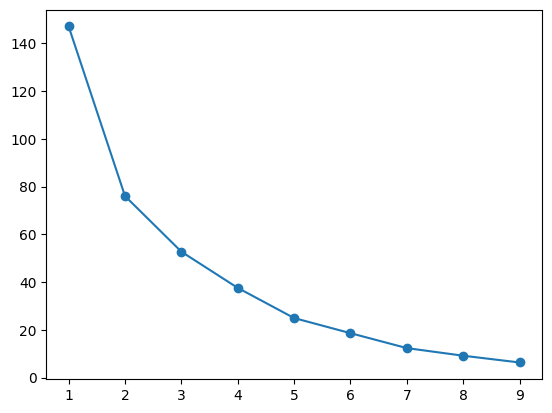

In [17]:
# Decide k
# 1.Compute sum of squares
sos = []
for i in range(1, 10):
    km_out = KMeans(n_clusters = i, n_init = 20)
    km_out.fit(d_s)
    sos.append(km_out.inertia_)
print(sos)

# 2.Plot
plt.plot(range(1, 10), sos, marker = 'o')
plt.show()

In [18]:
# I chose k = 3 by looking at the bend.
# Compute k-means with k = 3
km_res = KMeans(n_clusters = 3, n_init = 25).fit(d_s)

In [19]:
km_res.cluster_centers_

array([[ 0.24855075, -0.51792275, -0.43814229],
       [-1.38635986,  1.02048308,  0.8349759 ],
       [ 0.88235297,  2.36521786,  2.06458484]])

> I tried to plot a 3D plot here since I have exactly three features, it would be more intuitive to draw a 3D diagram. I studied the code in __[this article](https://www.kaggle.com/code/naren3256/kmeans-clustering-and-cluster-visualization-in-3d/notebook)__ to draw the diagram because it is similar to the idea of drawing a 2D diagram in the textbook.   
> The pattern is clear. The first cluster includes the straatnaams with rest and papier more, the second cluster includes the straatnaams with rest and papier less, and the third cluster includes the straatnaams with glas more.

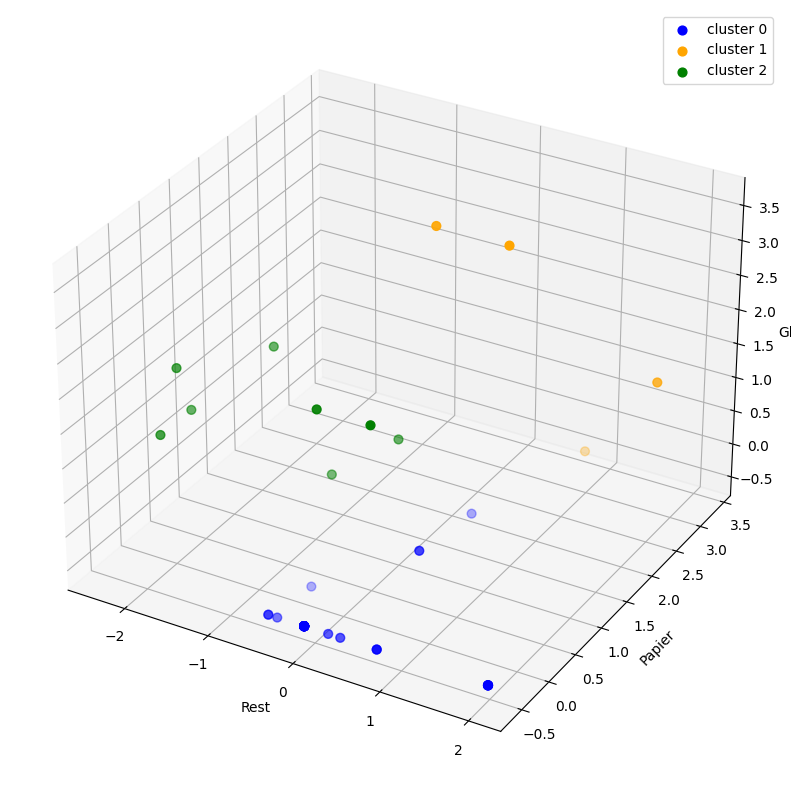

In [20]:
x = d_s
y_clusters = km_res.fit_predict(x)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[y_clusters == 0,0],x[y_clusters == 0,1],x[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(x[y_clusters == 1,0],x[y_clusters == 1,1],x[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(x[y_clusters == 2,0],x[y_clusters == 2,1],x[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
ax.set_xlabel('Rest')
ax.set_ylabel('Papier')
ax.set_zlabel('Glas')
ax.legend()
plt.show()

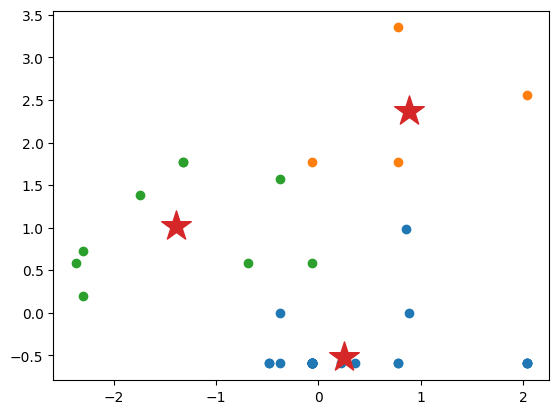

In [21]:
# I could also see the pattern using two features
for cluster in range(km_res.n_clusters): 
    plt.scatter(
        d_s[km_res.labels_ == cluster, 0], d_s[km_res.labels_ == cluster, 1]
    )
plt.scatter(
    km_res.cluster_centers_[:, 0], # compute center
    km_res.cluster_centers_[:, 1],
    s=500,
    marker="*",
)
plt.show()

### 2.3 The correlation between clusters and stadsdeels

> I wonder if there is correlation between the straatnaam clusters and the stadsdeels they belong to. Because It is possible that a certain stadsdeel is equipped with more glass waste containers.   
> However, I only provide a proof-of concept here, my results are not indicative. Since I did not retrieve all the data, there are only three stadsdeels, the frequency of one of them is very low.

In [22]:
d_k.reset_index(inplace = True)
d_k['stadsdeel'] = d_k.district.map(lambda x: x.split()[0])
d_k.district = d_k.district.map(lambda x: x[2:])
d_k['cluster'] = km_res.labels_
d_k.head()

,district,fracties.volumes_m3.Rest,fracties.volumes_m3.Papier,fracties.volumes_m3.Glas,stadsdeel,cluster
0,Akersingel,7.25,2.75,0.75,F,2
1,Akerwateringstraat,13.00,4.00,1.50,F,1
2,Anielewiczsingel,8.00,0.00,0.00,F,0
3,Balatonmeerlaan,4.00,2.50,1.50,F,2
4,Baldwinstraat,8.00,0.00,0.00,F,0


In [24]:
array1 = d_k['cluster'].value_counts(dropna = False)
array2 = d_k['stadsdeel'].value_counts(dropna = False)
s, p = scipy.stats.chisquare(array1, array2, ddof=0, axis=0)
print(f"Chisquare test: chisq={s:.2},p={p:.3}")
print(f"Is it significant? {p<0.05}")

## 3. Plotting

### 3.1 The percentage of each type of container in Amsterdam

> I could use the data from Sites API for plotting, but in this case, using data from Container API will be much more convinient.

<AxesSubplot: ylabel='count'>

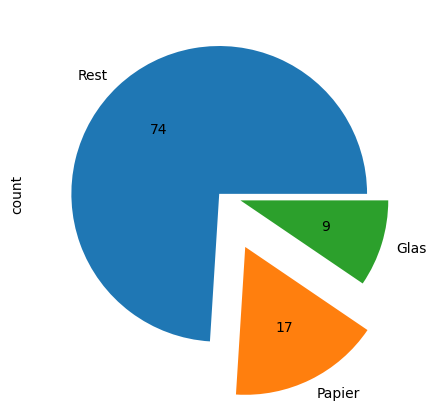

In [25]:
d_container['waste_name'].value_counts().plot.pie(autopct='%1.0f', explode = [0,.4,.15])

### 3.2 Average volumns and weight for different type of containers

In [26]:
d_container2 = d_container.groupby('waste_name').mean(numeric_only = True)
d_container2.reset_index(inplace = True)
d_container2.head()

,waste_name,id,active,waste_type,owner.id,container_type.id,container_type.volume,container_type.weight
0,Glas,7072.421053,0.105263,2.0,176.315789,637.052632,3.736842,534.736842
1,Papier,6011.757576,0.151515,6.0,164.303030,559.333333,4.939394,633.636364
2,Rest,6662.202703,0.108108,1.0,170.479730,530.270270,5.006757,645.314685


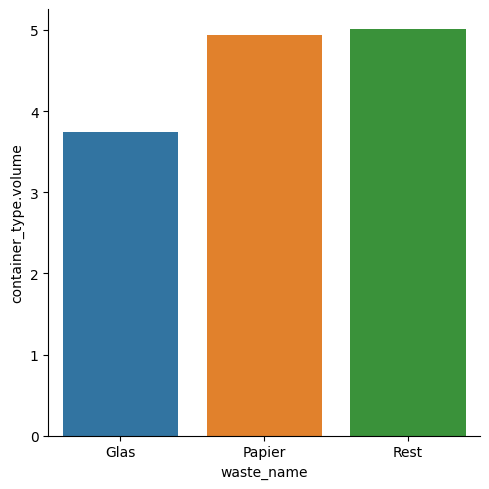

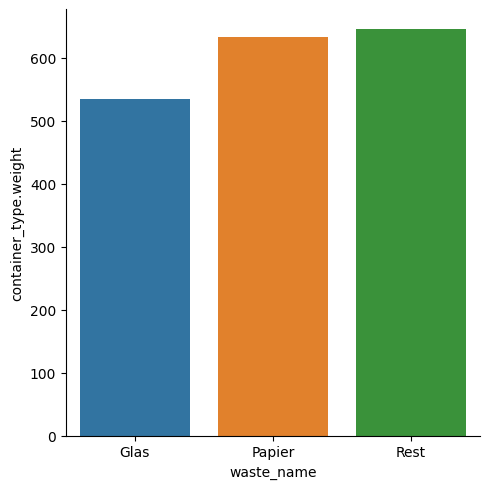

In [27]:
sns.catplot(x='waste_name', y='container_type.volume', 
            kind='bar', data=d_container2)
sns.catplot(x='waste_name', y='container_type.weight', 
            kind='bar', data=d_container2)

### 3.3 Trend of average volumns and weight of just-operated-containers over time

In [28]:
# Unify the type as str
# d_container['operational_date'].map(type)
d_container['operational_date'] = d_container['operational_date'].map(str)

# Extract the year of their operation data
d_container['year'] = d_container.operational_date.str.slice(0, 4)

In [29]:
# Combine data
d_combined = d_container.groupby('year').agg(
    volume = ('container_type.volume', 'mean'),
    weight = ('container_type.weight', 'mean')
).drop(index='None')
d_combined

,volume,weight
year,,
2006,4.800000,680.000000
2007,4.875000,675.000000
2008,4.750000,625.000000
2009,4.428571,635.714286
2010,5.000000,687.500000
2011,3.750000,525.000000
2012,4.833333,633.333333
2013,5.000000,675.000000
2014,5.000000,700.000000


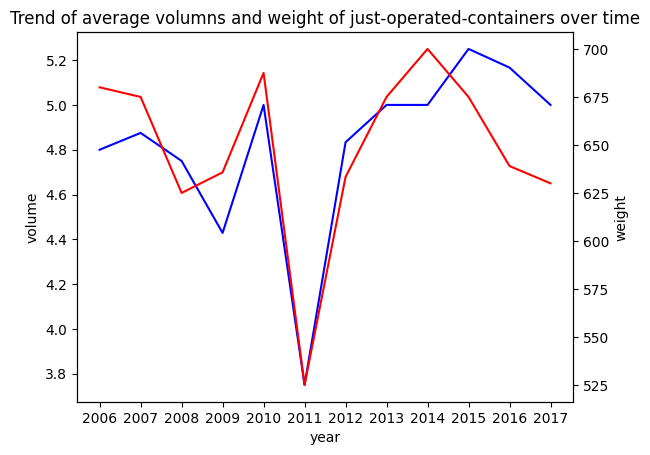

In [30]:
# Plotting
ax1 = plt.subplot()
ax2 = ax1.twinx()
sns.lineplot(x='year', y='volume', data=d_combined, color="blue", ax=ax1)
sns.lineplot(x='year', y='weight', data=d_combined, color="red", ax=ax2)

plt.title("Trend of average volumns and weight of just-operated-containers over time")
plt.show()

## 4. Expot the data

### 4.1 To file.csv

In [ ]:
d_use.to_csv("export1.csv", index = False, header = True)

### 4.2 To file.json

> Since my original function only return *json_normalize* object, I revised it a bit to make it return *dict* object.

In [ ]:
# Revise the function a bit to save and export a json file
def myretrieval2(url, page_number):
    allitems = []
    number_of_page = 1 # The original value is set as 1, which means starting from the 1st page.
    while True:
        r = requests.get(url)
        data = r.json()
        if number_of_page > page_number:
            print(f'Retrieved {len(allitems)}, this is from the first {page_number} pages.')
            break
        allitems.extend(data['results'])
        number_of_page += 1 # Get the page number of the next page
        url = data['_links']['next']['href'] # Get the URL of the next page
    return data

d_json = myretrieval2('https://api.data.amsterdam.nl/afval/v1/sites/', 10)

### 4.3 To file.txt

In [ ]:
with open('export2.json', 'w', encoding = 'utf-8') as f:
    json.dump(d_json, f)

In [ ]:
file = open('export3.txt', 'w', encoding = 'utf-8') 
for k,v in d_json.items():
    file.write(str(k)+' '+str(v)+'\n')
file.close()